**Project Start Date** <br>
17th December 2020 <br>

**Data Sources** <br>
https://www.kaggle.com/usaf/world-war-ii/notebooks <br> 
https://www.kaggle.com/smid80/weatherww2/data <br>

**Background** <br>
Aerial Bombing Operations in WW2 - Bombing operations data <br>

This dataset consists of digitized paper mission reports from WWII. Each record includes the date, conflict, geographic location, and other data elements to form a live-action sequence of air warfare from 1939 to 1945. The records include U.S. and Royal Air Force data, in addition to some Australian, New Zealand and South African air force missions.

Weather Conditions in WW2 (Weather Stations / Weather Conditions) <br>
The dataset contains information on weather conditions recorded on each day at various weather stations around the world. Information includes precipitation, snowfall, temperatures, wind speed and whether the day included thunder storms or other poor weather conditions.

**Aim of this project** <br>
Use Sweetviz - A powerful package to speed up EDA, saving reports as HTML files and with the ability to compare test and train datasets 
Impletment the use of Ridge Plots as part of EDA to understand variabe distribution analysis 
One method of Outlier Detection & Analysis
Implement a GLM model that predicts the maximum weather temperature (based on the minimum temperature)
Test Assumptions of GLMs & Residual Analysis: Correlation of errors with predictor variables
Dockerise the notebook


**Analysis regarding Data Quality** <br>
Understanding of the sampling procedure 
- Since our project team did not participate in planning the study or data collection, it is possible that we are missing crucial context which could render our conclusions invalid. <br>

Potential biases <br> 
Real-world actions that generated the data you inherited <br>

**Objectives & Hypothesises to Test (max. 10)** <br>
<u>Exploratory Analysis</u>
- High level discriptive statistics 
- Do any values look to be recorded to accommodate missing values? e.g. 999, 9999 etc.
- Assessment of feature distributions
- Assessment of feature relationships:
    - What defines the feature 'poor weather' conditions?
    - Is there a relationship between the daily minimum and maximum temperature (TimeSeries Analysis)?
    - It is expected that average temperatures are colder in winter months than summer months
    - It is expected that more snowfall occurs in the winter months (for northern hemisphere regions)
    - It is expected that more Precipitation occurs in the winter months (for northern hemisphere)
    - It is expected that lower temperatures correlate with higher snowfall and precipation 
    - It is expected that higher levels above the sea have greater precipation
    - It is expected that the accuracy of recordings based on stations may not be uniform (outlier detection)
<br>

**Statistical Model/Machine Learning Applications**
- Create a dummy model (Predict the average temperature for that monthly/quarter)
- Explain the train/test split
- Predict the maximum temperature given the minimum temperature (GLM Models & Bayesian Versions)?
- Explain appropriate error metric
- Explain class balance and any required action
- Explain what features are developed and transformations applied
- Explain if the model is exhibiting high bias or high variance and how this can be improved
    - Plot learning curves to deduce high bias/high variance and conclude what means could be applied to solve these issues
- Explain where the model seems to perform poorly - In what situations does the model make mistakes?

**Additional Learning notes from Reviewing 3 other Kaggle Notebooks** <br> 

**Next steps** <br>

**References**


In [1]:
import warnings
warnings.filterwarnings('ignore')

# Package Requirements
import os
import sys
# !{sys.executable} -m pip install markdown
# !{sys.executable} -m pip install sweetviz
# !{sys.executable} -m pip install joypy

In [3]:
# Data Wrangling
import pandas as pd
import numpy as np
import datetime 

# Data Exploration and Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import sweetviz as sv
import joypy

In [4]:
os.getcwd()

'/Users/Rej1992/Documents/GitHub/RegressionModels/notebooks'

In [99]:
aerial_bombing_data = pd.read_csv('/Users/Rej1992/Documents/GitHub/RegressionModels/data/01_raw/ww2_boming_operations.csv')
weather_summary = pd.read_csv('/Users/Rej1992/Documents/GitHub/RegressionModels/data/01_raw/WeatherTempPrediction.csv')
weather_station_location = pd.read_csv('/Users/Rej1992/Documents/GitHub/RegressionModels/data/01_raw/WeatherStationLocations.csv')

data_list = []
data_list.append(aerial_bombing_data)
data_list.append(weather_summary)
data_list.append(weather_station_location)

In [100]:
# State the assumptions you’re being forced to make.
# Write up caveat notes to be included in the appendix of your final report
# Write cautionary notes that warn the decision-maker (and your other readers) that conclusions from the study will 
# need to be downgraded due to potential data issues

In [101]:
for i in data_list:
    print("Dataframe Dimensions")
    print(i.shape)
    print("")

    print("Dataframe Columns and respective types")
    print(i.dtypes)
    print("")

    print("Percentage of Missing Data")
    print(i.isnull().sum() * 100 / len(i))
    
    print("")

Dataframe Dimensions
(178281, 46)

Dataframe Columns and respective types
Mission ID                                 int64
Mission Date                              object
Theater of Operations                     object
Country                                   object
Air Force                                 object
Unit ID                                   object
Aircraft Series                           object
Callsign                                  object
Mission Type                              object
Takeoff Base                              object
Takeoff Location                          object
Takeoff Latitude                          object
Takeoff Longitude                        float64
Target ID                                 object
Target Country                            object
Target City                               object
Target Type                               object
Target Industry                           object
Target Priority                           ob

## Data Analysis

In [102]:
# Investiage options to link the dataframes with a unique key: weather_summary and weather_station_location look to be 
# connected via STA and WBAN respectively 
def uncommon_elements(list1, list2):
    ## Add something clever so the look up is always against the set with the largest number of unique records
    
    return [element for element in list2 if element not in list1]

STA = set(weather_summary.STA)
print(len(STA))

WBAN = set(weather_station_location.WBAN)
print(len(WBAN))

print('Sets are of the same data type: ', type(weather_summary.STA) == type(weather_station_location.WBAN))

print('Stations that are uncommon across both sets: ', uncommon_elements(STA, WBAN))

159
161
Sets are of the same data type:  True
Stations that are uncommon across both sets:  [15605, 15604]


In [108]:
combined_data = pd.merge(weather_summary, 
                         weather_station_location, 
                         how = 'inner', # takes care of only keeping records in both sets
                         left_on='STA',
                         right_on='WBAN')

print(len(combined_data))

119040


## Columns for Combined Data
**STA**
- STA: represent the Weather Station
- Not all STA codes represent the same time frequency 
- Object Data Type

**Date** 
- Date has been split into DA MO and YR respectively, note the century has been dropped when recording the YR
- Date Data Type (will require engineering in order to be used for ML

**Precip** 
- Precipitation in mm. This consists of numerical values and 'T' for 16,754 entries. This looks to be a mistake in the data collection (Impute precip == 0 for these cases)
- Numeric (float) Data Type

**MaxTemp and MinTemp** 
- These are features that have been transformed into celcius from fahrenheit readings MAX/MIN and these have been recorded to 6 decimal places. The degrees celcius value has additionally been converted to an average. Using celcius will have a smaller range than the fahrenheit records. Patterns may be more easily seen based fahrenheit columns 
- Numeric (float) Data Type

**MEA** 
- This is the mean for the fahrenheit MAX / MIN columns and this has been rounded to 1 d.p. Drop this columns and calculate the extact mean value
- Numeric (float) Data Type

**Snowfall**
- This looks to be measures in terms of the amount of snow that fell in mm. The units are not obvious so there are two options
- Either assume the units are centiments by attempting to research more about the data OR normalise all the columns so they are on the same scale
- Numeric (float) Data Type

**SNF**
- After research it is unclear what SNF relates too and seems to gave a range of 0 - 3.4 (Agree to remove)
- This supports the necessity to normalise the data for the numeric columns due to the possibility of differing units across columns
- Numeric (float) Data Type

**PRCP**
- This column looks to have been scaled by a factor of 1/25.4*Precip (Agree to remove)
- Numeric (float) Data Type

**TSHDSBRSGF**
- This is a repeat for PoorWeather so can be removed

**WBAN**
- Same as STA, representing the Weather Station
- Not all Weather Stations are located in the USA (unique STATE/COUNTRY ID = 63)
- This will be duplicated due to the merge so can be removed 
- Object Data Type

**NAME**
- This is the name of the weather station. It has a many:1 relationship with State/Country ID i.e. more than one station can be present per country 
- Object Data Type (Nominal)

**STATE/COUNTRY ID**
- This is the location of the weather station at state/country level
- Object Data Type (Nominal)

**LAT**
- This is the decimal latitude in string format 

**LON**
- This is the decimal latitude in string format 

**ELEV**
- Explanation not given - Expected to be level above the sea 
- Note that an elevation of 9999 means unknown
- Numeric (float) Data Type

**Latitude**
- This is the decimal latitude calculated from the LAT/LON provided (use this over string as in format for ML)

**Longitude**
- This is the decimal longitude calculated from the LAT/LON provided (use this over string as in format for ML)

### Data Cleaning - Remove duplicate Rows & Columns
- Remove all columns that exhibit over 90% missing values
- Remove celcius columns 'MaxTemp', 'MinTemp', 'MeanTemp' and 'MEA'
- Remove duplicated/scaled columns: 'PRCP', 'TSHDSBRSGF'
- Remove PoorWeather for the inital analysis as unclear how the data has been recorded 
- Remove the primary key to join dataframes SNF & WBAN
- Remove LAT as string format
- Remove LON as string format
- Remove those columns with zero variance
- Remove duplicated rows

In [109]:
# Handling missing data - Remove any columns with over 90% missing data 
def remove_missing_values(data, thresold_limit = 0.9):
    
    return data.loc[:, data.isnull().sum() < thresold_limit*data.shape[0]]

combined_data = remove_missing_values(combined_data)

# Remove additional columns based on explanation above
combined_data.drop(['MaxTemp', 
                    'MinTemp', 
                    'MeanTemp', 
                    'MEA', 
                    'TSHDSBRSGF', 
                    'PRCP', 
                    #'PoorWeather', 
                    'SNF', 
                    'WBAN',
                    'LAT', 
                    'LON'], axis=1, inplace=True)

# Data Quality Expectations: Test for zero variance 
combined_data = combined_data.loc[:, combined_data.apply(pd.Series.nunique) != 1]

# Data Quality Expectations: Duplicated Records
print('Duplicated rows for index: ', combined_data[combined_data.duplicated()].index)
#print(len(combined_data))
combined_data = combined_data.drop_duplicates()
#print(len(combined_data))

Duplicated rows for index:  Int64Index([94660, 94661, 94662, 94663, 94664, 94665, 94666, 94667, 94668,
            94669],
           dtype='int64')


## Data Cleaning

### Correct Data Types

In [111]:
# Correct Date
def correct_dates(data, cols):
    
    return pd.to_datetime(combined_data[cols], format = '%Y-%m-%d')

# Correct Object Types
def correct_objects(data, cols):
    
    return data[cols].astype('object')

# Correct String Types
def correct_string(data, cols):
    
    return data[cols].astype(str)

combined_data.Date = correct_dates(combined_data, 'Date')

combined_data.STA = correct_objects(combined_data, 'STA')
combined_data.YR = correct_objects(combined_data, 'YR')
combined_data.MO = correct_objects(combined_data, 'MO')
combined_data.DA = correct_objects(combined_data, 'DA')

combined_data.Snowfall = correct_string(combined_data, 'Snowfall')
combined_data.PoorWeather = correct_string(combined_data, 'PoorWeather')

In [112]:
my_report = sv.analyze(combined_data)
my_report.show_html()


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### Imputation of Missing Values

In [113]:
# Deal with Missing/Inaccurate values and correct data types 
def impute_missing_values(data, cols):
    
    return np.where((data[cols] == 'T') | (data[cols] == ' '), 0, data[cols])

# Correct float types
def correct_floats(data, cols):
    
    return data[cols].astype('float')

# As the target variable contains 4% missing values remove these to avoid inaccurate assumptions
def remove_missing_max(data):
    
    return data[data.loc[:, 'MAX'].notnull()]

def remove_missing_min(data):
    
    return data[data.loc[:, 'MIN'].notnull()]

combined_data.Precip = impute_missing_values(combined_data, 'Precip')
combined_data.Precip = correct_floats(combined_data, 'Precip')

combined_data = remove_missing_max(combined_data)
combined_data = remove_missing_min(combined_data)

In [114]:
# Verify that the above logic has been correctly applied 
print(combined_data[combined_data.loc[:, 'MAX'].isnull()])
print(combined_data[combined_data.loc[:, 'MIN'].isnull()])
print((combined_data.isnull().sum() * 100) / len(combined_data))

Empty DataFrame
Columns: [STA, Date, Precip, Snowfall, PoorWeather, YR, MO, DA, MAX, MIN, NAME, STATE/COUNTRY ID, ELEV, Latitude, Longitude]
Index: []
Empty DataFrame
Columns: [STA, Date, Precip, Snowfall, PoorWeather, YR, MO, DA, MAX, MIN, NAME, STATE/COUNTRY ID, ELEV, Latitude, Longitude]
Index: []
STA                 0.0
Date                0.0
Precip              0.0
Snowfall            0.0
PoorWeather         0.0
YR                  0.0
MO                  0.0
DA                  0.0
MAX                 0.0
MIN                 0.0
NAME                0.0
STATE/COUNTRY ID    0.0
ELEV                0.0
Latitude            0.0
Longitude           0.0
dtype: float64


### Linear Combination Check

In [116]:
combined_data.corr()

,Precip,MAX,MIN,ELEV,Latitude,Longitude
Precip,1.000000,0.004358,0.091849,0.080995,-0.102590,0.009129
MAX,0.004358,1.000000,0.873746,0.043016,-0.554533,0.044043
MIN,0.091849,0.873746,1.000000,0.060579,-0.601654,-0.089958
ELEV,0.080995,0.043016,0.060579,1.000000,-0.068801,0.000770
Latitude,-0.102590,-0.554533,-0.601654,-0.068801,1.000000,-0.130366
Longitude,0.009129,0.044043,-0.089958,0.000770,-0.130366,1.000000


<AxesSubplot:>

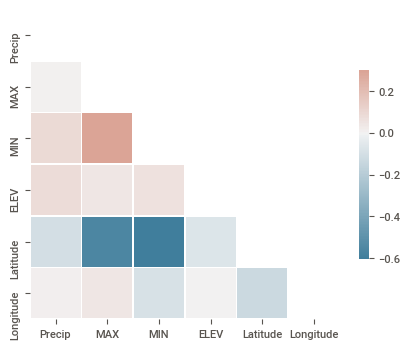

In [117]:
# Compute the correlation matrix
corr = combined_data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Handling nominal and ordinal categorical values
Types: 
- Ordinal: Convert into numeric values retaining the datas natural order
- Nominal: One Hot encoding/Label Encoding
- Dichotomous (Binary): Convert values into indicator values 1/0 <br>
The only columns that require revision at this stage are 'NAME' and 'STATE/COUNTRY ID'


In [118]:
combined_data.select_dtypes('object').columns

Index(['STA', 'Snowfall', 'PoorWeather', 'YR', 'MO', 'DA', 'NAME',
       'STATE/COUNTRY ID'],
      dtype='object')

In [139]:
def correct_category_datatype(data, cols):
    
    return data[cols].astype('category')

combined_data.NAME = correct_category_datatype(combined_data, 'NAME')
combined_data['STATE/COUNTRY ID'] = correct_category_datatype(combined_data, 'STATE/COUNTRY ID')

In [141]:
combined_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118532 entries, 0 to 119039
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   STA               118532 non-null  object        
 1   Date              118532 non-null  datetime64[ns]
 2   Precip            118532 non-null  float64       
 3   Snowfall          118532 non-null  object        
 4   PoorWeather       118532 non-null  object        
 5   YR                118532 non-null  object        
 6   MO                118532 non-null  object        
 7   DA                118532 non-null  object        
 8   MAX               118532 non-null  float64       
 9   MIN               118532 non-null  float64       
 10  NAME              118532 non-null  category      
 11  STATE/COUNTRY ID  118532 non-null  category      
 12  ELEV              118532 non-null  int64         
 13  Latitude          118532 non-null  float64       
 14  Long

In [142]:
# Pandas `.get_dummies()` method
NAME_dummies_df = pd.concat([combined_data, pd.get_dummies(combined_data['NAME'], prefix='category')],axis=1)
STATE_dummies_df = pd.concat([combined_data, pd.get_dummies(combined_data['STATE/COUNTRY ID'], prefix='category')],axis=1)

# now drop the original 'category' column (you don't need it anymore)
NAME_dummies_df.drop(['NAME'],axis=1, inplace=True)
STATE_dummies_df.drop(['STATE/COUNTRY ID'],axis=1, inplace=True)

In [144]:
STATE_dummies_df

,STA,Date,Precip,Snowfall,PoorWeather,YR,MO,DA,MAX,MIN,...,category_PR,category_SG,category_SO,category_SP,category_TD,category_TI,category_TO,category_TS,category_TU,category_UK
0,10001,1942-07-01,1.016,0.0,nan,42,7,1,78.0,72.0,...,0,0,0,0,0,0,0,0,0,0
1,10001,1942-07-02,0.000,0.0,nan,42,7,2,84.0,71.0,...,0,0,0,0,0,0,0,0,0,0
2,10001,1942-07-03,2.540,0.0,nan,42,7,3,79.0,72.0,...,0,0,0,0,0,0,0,0,0,0
3,10001,1942-07-04,2.540,0.0,nan,42,7,4,80.0,72.0,...,0,0,0,0,0,0,0,0,0,0
4,10001,1942-07-05,0.000,0.0,nan,42,7,5,80.0,71.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119035,82506,1945-12-27,0.000,0.0,nan,45,12,27,83.0,65.0,...,0,0,0,0,0,0,0,0,0,0
119036,82506,1945-12-28,9.906,0.0,1.0,45,12,28,85.0,65.0,...,0,0,0,0,0,0,0,0,0,0
119037,82506,1945-12-29,0.000,0.0,1.0,45,12,29,83.0,65.0,...,0,0,0,0,0,0,0,0,0,0
119038,82506,1945-12-30,0.000,0.0,nan,45,12,30,83.0,65.0,...,0,0,0,0,0,0,0,0,0,0


In [140]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
prefix = 'category'
ohe = OneHotEncoder(sparse=False)
ohe = ohe.fit(combined_data[['category']])
onehot_encoded = ohe.transform(combined_data[['category']])
features_names_prefixed = [ f"{prefix}_{category}" for category in onehot_encoder.categories_[0]]
category_enncoded_df = pd.concat([combined_data, pd.DataFrame(onehot_encoded, columns=features_names_prefixed)], axis=1)
# now drop the original 'category' column (you don't need it anymore)
category_enncoded_df.drop(['category'],axis=1, inplace=True)

KeyError: "None of [Index(['category'], dtype='object')] are in the [columns]"

### Exploratory Data Analysis 
**Hypothesis & Expectations to Test**
- Is this a Global study? What are the locations associated with the experiment? [x]
- High level discriptive statistics [x]
- Assessment of feature distributions [x]
- Do any values look to be recorded to accommodate missing values? e.g. 999, 9999 etc.
- Assessment of feature relationships:
    - What is the relationship of each variable with the target?
- Data Integrity Preprocessing Steps
    - It is expected that average temperatures are colder in winter months than summer months
    - It is expected that more snowfall occurs in the winter months (for northern hemisphere regions)
    - It is expected that more Precipitation occurs in the winter months (for northern hemisphere)
    - It is expected that lower temperatures correlate with higher snowfall and precipation 
    - It is expected that higher levels above the sea have greater precipation
    - It is expected that the accuracy of recordings based on stations may not be uniform (outlier detection)
- Create a function that differentiates between the Northern & Southern Hemisphere if using monthly data
- Time Series Analysis (max. 3 graphs/analyses)

**References** <br>
https://towardsdatascience.com/powerful-eda-exploratory-data-analysis-in-just-two-lines-of-code-using-sweetviz-6c943d32f34 <br>
https://towardsdatascience.com/pandas-profiling-sweetviz-8849704cadd7 <br>
https://towardsdatascience.com/ridgeline-plots-the-perfect-way-to-visualize-data-distributions-with-python-de99a5493052 <br>
https://towardsdatascience.com/all-you-want-to-know-about-preprocessing-data-preparation-b6c2866071d4 <br>

**Is this a Global study? What are the locations associated with the experiment?**

In [ ]:
# Categorical data doesn’t have duplicates because of whitespaces, lower/upper cases

In [119]:
combined_data['STATE/COUNTRY ID'].unique()

array(['GH', 'LI', 'GY', 'BZ', 'PM', 'CS', 'SG', 'BR', 'LC', 'AT', 'NU',
       'TD', 'DR', 'HA', 'JM', 'NK', 'GU', 'AL', 'MT', 'CU', 'TI', 'BA',
       'MC', 'AZ', 'BE', 'UK', 'IL', 'GL', 'NZ', 'PI', 'HI', 'NI', 'ET',
       'DY', 'OM', 'IN', 'EG', 'BN', 'ER', 'PK', 'TS', 'IY', 'LY', 'GR',
       'IQ', 'TU', 'IR', 'FR', 'SP', 'PH', 'JP', 'KO', 'EQ', 'PR', 'CT',
       'KU', 'PF', 'TO', 'NG', 'SO', 'AU', 'NH', 'FJ'], dtype=object)

In [120]:
combined_data.NAME.unique()

array(['ACCRA', 'CAPE PALMAS', 'FISHERMANS LAKE',
       'MARSHALL/ROBERTS FIELD', 'GEORGETOWN', 'CLEVELANDIA',
       'BALBOA/ALBROOK', 'REY ISLAND', 'JAQUE', 'HOWARD', 'FORT KOBBE',
       'POCRI', 'RIO HATO', 'DAVID', 'SAN JOSE', 'PARRITA',
       'DAKAR/EKNES FIELD', 'DAKAR/MALLARD FIELD', 'CHRISTS CHURCH',
       'ST LUCIA/ISLAND', 'ST JOHNS/COOLIDGE FIELD', 'WILLEMSTAD',
       'WALLER/BWI', 'CIUDAD TRUJILLO', 'PORT AU PRINCE', 'KINGSTON',
       'MERCEDES', 'GUATEMALA CITY', 'TINDOUF', 'ATAR', 'CAMAGUEY',
       'SOUTH CAICOS ISLAND', 'GREAT EXUMA ISLAND', 'SAN ANTONIO',
       'CASABLANCA/CAZES FIELD', 'MARRAKECH', 'OUJDA', 'TOUAHAR', 'LAJES',
       'BERMUDA', 'WARRINGTON', 'CAMP DELTA', 'KEFLAVIK', 'REYKJAVIK',
       'NARSARSSUAK', 'SIMIUTAK', 'SONDRESTROM', 'CHRISTMAS ISLAND/AAF',
       'PALMYRA ISLAND/LINE ISLANDS', 'LYMAN FIELD/AAF', 'MOLOKAI/AP 524',
       'HICKAM/AFB', 'MOKULEIA FIELD/AAF', 'WHEELER/AFB 810.1',
       'BURNS FIELD/AAF', 'APAPA', 'KANO', 'MAIDUGURI', '

In [121]:
pd.crosstab(combined_data['STATE/COUNTRY ID'], combined_data.NAME)

NAME,ABADAN,ACCRA,ADANA,AGRA,AIN EL,AMBERLY,AMENDOLA,AMENDOLA/MU 9,AMIRABAD POST,AMURI/FIELD AAF,...,TELERGMA,TINDOUF,TONGATABU ISLAND,TOUAHAR,VAL DE CANS,WALLER/BWI,WARRINGTON,WHEELER/AFB 810.1,WHEELUS,WILLEMSTAD
STATE/COUNTRY ID,,,,,,,,,,,,,,,,,,,,,
AL,0,0,0,0,383,0,0,0,0,0,...,502,818,0,0,0,0,0,0,0,0
AT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AU,0,0,0,0,0,847,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AZ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
BA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TI,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TO,0,0,0,0,0,0,0,0,0,0,...,0,0,179,0,0,0,0,0,0,0
TS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**High Level Descriptive Statistics**

In [122]:
combined_data.describe()

,Precip,MAX,MIN,ELEV,Latitude,Longitude
count,118532.000000,118532.000000,118532.000000,118532.000000,118532.000000,118532.000000
mean,3.226785,81.003231,64.274129,415.450849,17.564420,-15.605283
std,10.811075,14.870509,14.483608,1699.686883,19.788457,88.801472
min,0.000000,-28.000000,-37.000000,1.000000,-27.600000,-175.000000
25%,0.000000,78.000000,59.000000,9.000000,6.750000,-79.500000
50%,0.000000,85.000000,70.000000,26.000000,17.900000,-22.616667
75%,0.762000,89.000000,74.000000,88.000000,27.683333,44.866667
max,307.340000,122.000000,94.000000,9999.000000,67.016667,177.366667


**Assessment of feature distributions**

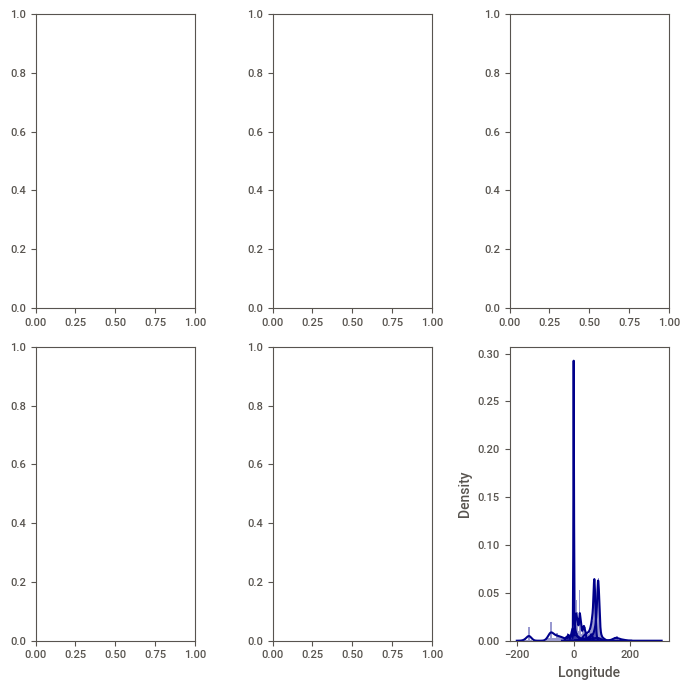

In [97]:
# Density Plots for Numerical Columns
numeric_columns = combined_data.select_dtypes(include=['float64']).columns

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(7,7))

for i in numeric_columns:
    sns.distplot(combined_data[i], hist=True, kde=True, color = 'darkblue')

plt.tight_layout()
plt.show()
plt.clf()
plt.close()

In [ ]:
object_columns = combined_data.select_dtypes(include=['object']).columns
object_columns[1]

In [ ]:
combined_data['Snowfall'].value_counts().plot(kind='bar')

In [ ]:
object_columns[1:]

In [ ]:
# Barplots for Categorical Data
object_columns = combined_data.select_dtypes(include=['object']).columns
object_columns = object_columns[1:] #  Cannot plot STA

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(7,7))

for i in object_columns:
    combined_data[i].value_counts().plot(kind='bar')
    
    plt.tight_layout()
    plt.show()
    plt.clf()
    plt.close()

In [ ]:
object_columns.columns

In [ ]:
pd.crosstab(combined_data.YR, combined_data.MO)

In [124]:
from joypy import joyplot
feature_data = combined_data[['Date', 'NAME', 'MIN', 'MAX']]

In [130]:
feature_data.NAME.value_counts()

WHEELER/AFB 810.1         2192
BALBOA/ALBROOK            2185
MOLOKAI/AP 524            2152
HICKAM/AFB                2101
SAN JOSE                  1916
                          ... 
OKINAWA/RYUKYU ISLANDS      50
WHEELUS                     47
TACHIKAWA                   46
AMENDOLA/MU 9               31
EL DJEM                     13
Name: NAME, Length: 157, dtype: int64

In [131]:
ridge_data = feature_data.query("NAME == 'WHEELER/AFB 810.1'")
ridge_data = ridge_data.drop('NAME', axis=1)
ridge_data['Date'] = ridge_data['Date'].astype('datetime64')
ridge_data['Month'] = ridge_data['Date'].dt.month_name()

ridge_data.head()

,Date,MIN,MAX,Month
57877,1940-01-01,63.0,74.0,January
57878,1940-01-02,61.0,74.0,January
57879,1940-01-03,60.0,75.0,January
57880,1940-01-04,65.0,75.0,January
57881,1940-01-05,59.0,72.0,January


In [132]:
from pandas.api.types import CategoricalDtype

cat_month = CategoricalDtype(
    ['January', 'February', 'March', 'April', 'May', 'June',
     'July', 'August', 'September', 'October', 'November', 'December']
)

ridge_data['Month'] = ridge_data['Month'].astype(cat_month)

ridge_data.dtypes

Date     datetime64[ns]
MIN             float64
MAX             float64
Month          category
dtype: object

<Figure size 600x400 with 0 Axes>

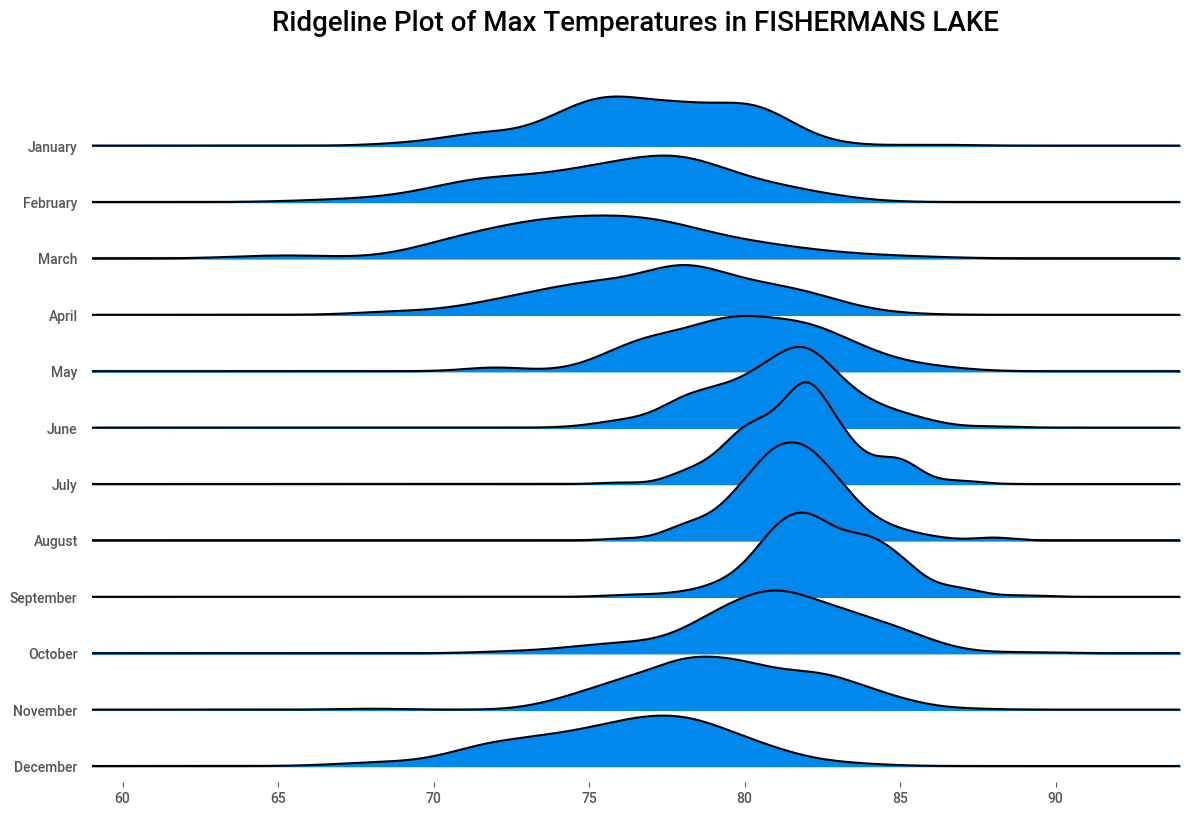

In [133]:
plt.figure()

joyplot(
    data=ridge_data[['MAX', 'Month']], 
    by='Month',
    figsize=(12, 8)
)

plt.title('Ridgeline Plot of Max Temperatures in WHEELER/AFB 810.1', fontsize=20)
plt.show()

<Figure size 600x400 with 0 Axes>

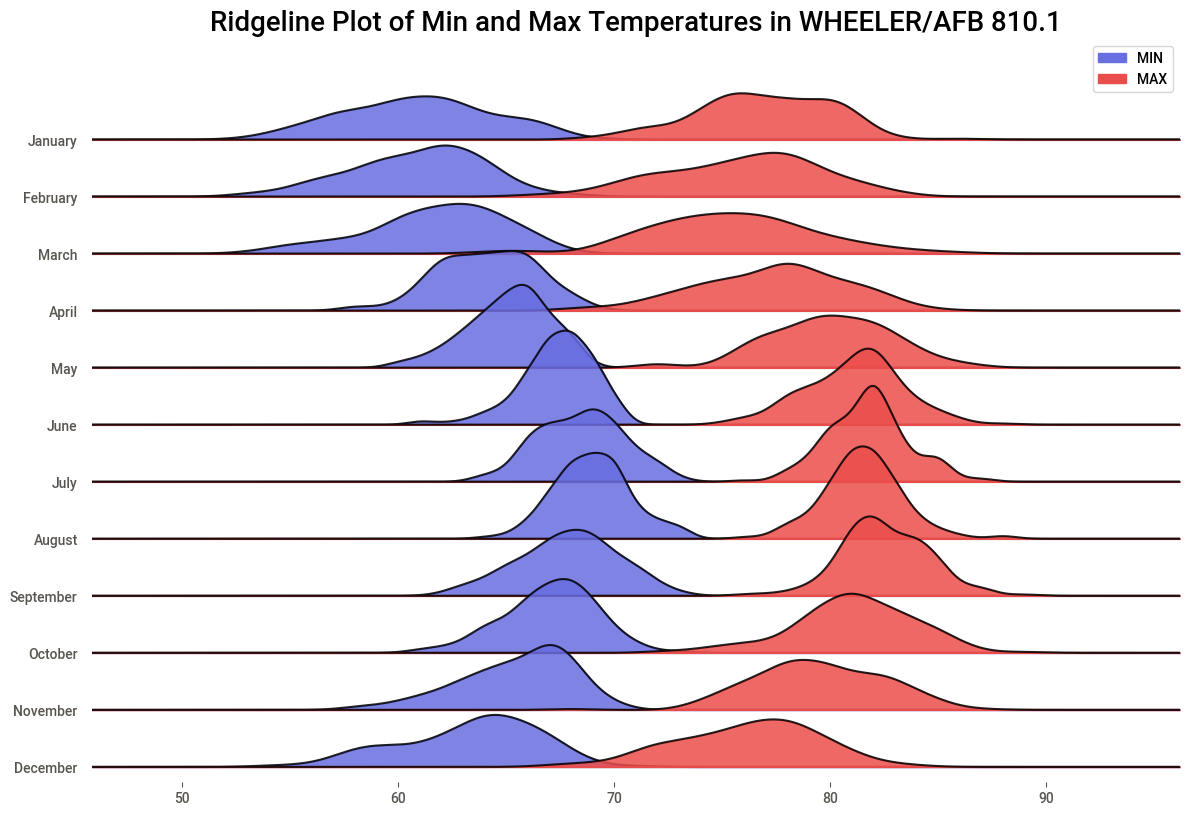

In [134]:
plt.figure()

ax, fig = joyplot(
    data=ridge_data[['MIN', 'MAX', 'Month']], 
    by='Month',
    column=['MIN', 'MAX'],
    color=['#686de0', '#eb4d4b'],
    legend=True,
    alpha=0.85,
    figsize=(12, 8)
)
plt.title('Ridgeline Plot of Min and Max Temperatures in WHEELER/AFB 810.1', fontsize=20)
plt.show()

In [ ]:
# Write clean data to 02_intermediate data folder
#weather_summary.to_csv('/Users/Rej1992/Documents/GitHub/RegressionModels/data/02_intermediate/data_cleaning.csv')

### Data Cleaning - Feature Engineering
- Deal with date columns. There are 4 most common methods to transform date to numeric format:
    - Unix timestamp: Time since 1970 (not applicable as our data is from period 1940 - 1944
    - KSP date formate: Year and quarter are obvious and attempts to retain similar intervals
    - Divide into several features (DA / MO / YR): Data already formated to accommodate these features
    - Manual Feature Creation: Time from or to an event
- Normalization and standardization of features: Precip/Snowfall/SNF/ELEV
- Dimensionality Reduction <br>

https://towardsdatascience.com/smarter-ways-to-encode-categorical-data-for-machine-learning-part-1-of-3-6dca2f71b159 

**Date Time Features** <br>
Note: From there analysis it is clear that some areas from both the northern and southern hemisphere have been included as part of the research so care should be taken when dealing with datetime features

In [135]:
import datetime as dt
import calendar

def to_ksp_format(datetime):
    year = datetime.year
    day_from_jan_1 = (datetime - dt.datetime(year, 1, 1)).days
    is_leap_year = int(calendar.isleap(year))
    
    return year + (day_from_jan_1 - 0.5) / (365 + is_leap_year)

combined_data['ksp_date'] = combined_data['Date'].apply(to_ksp_format)

In [136]:
combined_data.head()

,STA,Date,Precip,Snowfall,PoorWeather,YR,MO,DA,MAX,MIN,NAME,STATE/COUNTRY ID,ELEV,Latitude,Longitude,ksp_date
0,10001,1942-07-01,1.016,0.0,nan,42,7,1,78.0,72.0,ACCRA,GH,62,5.6,-0.3,1942.494521
1,10001,1942-07-02,0.000,0.0,nan,42,7,2,84.0,71.0,ACCRA,GH,62,5.6,-0.3,1942.497260
2,10001,1942-07-03,2.540,0.0,nan,42,7,3,79.0,72.0,ACCRA,GH,62,5.6,-0.3,1942.500000
3,10001,1942-07-04,2.540,0.0,nan,42,7,4,80.0,72.0,ACCRA,GH,62,5.6,-0.3,1942.502740
4,10001,1942-07-05,0.000,0.0,nan,42,7,5,80.0,71.0,ACCRA,GH,62,5.6,-0.3,1942.505479


In [ ]:
#weather_summary = pd.read_csv('/Users/Rej1992/Documents/GitHub/RegressionModels/data/02_intermediate/data_cleaning.csv')

In [ ]:
# Calculate the average based on the fahrenheit columns
weather_summary['MeanTemp_F'] = (weather_summary['MAX'] + weather_summary['MIN'])/2

# Create a simplier binary feature for snowfall occurrence
weather_summary['Snowfall_bin'] =  np.where(weather_summary.Snowfall.isnull(), 0, 1)

# Add full state names to the analysis

STATES_TUPLE = [("AL","Alabama"),
                ("AK","Alaska"),
                ("AZ","Arizona"),
                ("AR","Arkansas"),
                ("CA", "California"),
                ("CO", "Colorado"),
                ("CT","Connecticut"),
                ("DC","Washington DC"),
                ("DE","Delaware"),
                ("FL","Florida"),
                ("GA","Georgia"),
                ("HI","Hawaii"),
                ("ID","Idaho"),
                ("IL","Illinois"),
                ("IN","Indiana"),
                ("IA","Iowa"),
                ("KS","Kansas"),
                ("KY","Kentucky"),
                ("LA","Louisiana"),
                ("ME","Maine"),
                ("MD","Maryland"),
                ("MA","Massachusetts"),
                ("MI","Michigan"),
                ("MN","Minnesota"),
                ("MS","Mississippi"),
                ("MO","Missouri"),
                ("MT","Montana"),
                ("NE","Nebraska"),
                ("NV","Nevada"),
                ("NH","New Hampshire"),
                ("NJ","New Jersey"),
                ("NM","New Mexico"),
                ("NY","New York"),
                ("NC","North Carolina"),
                ("ND","North Dakota"),
                ("OH","Ohio"),
                ("OK","Oklahoma"),
                ("OR","Oregon"),
                ("PA","Pennsylvania"),
                ("RI","Rhode Island"),
                ("SC","South Carolina"),
                ("SD","South Dakota"),
                ("TN","Tennessee"),
                ("TX","Texas"),
                ("UT","Utah"),
                ("VT","Vermont"),
                ("VA","Virginia"),
                ("WA","Washington"),
                ("WV","West Virginia"),
                ("WI","Wisconsin"),
                ("WY","Wyoming")]


# Add sine and cos features for seasonal elements 

In [ ]:
# Write clean data to 02_intermediate data folder
weather_summary.to_csv('/Users/Rej1992/Documents/GitHub/RegressionModels/data/03_processed/data_std_feature_eng.csv')

# Save the features to a pickle file


#weather_summary_tm.to_csv('/Users/Rej1992/Documents/GitHub/RegressionModels/data/03_processed/data_tm_feature_eng.csv')

In [ ]:
weather_summary['Snowfall_bin'].value_counts().sort_values().plot(kind = 'barh')

In [ ]:
# call regplot on each axes
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)

sns.displot(weather_summary, x="MIN", ax=ax1)
sns.displot(weather_summary, x="MAX", ax=ax2)

In [ ]:
sns.displot(weather_summary, x="MAX", hue="YR", kind="kde")

In [ ]:
weather_summary[weather_summary['STA'] == 10001]

**Data Analysis & Visualization of features**
- Timeseries Dataframe: weather_summary_tm

In [ ]:
## Sort the data into date order and reset index
## Create a new timeseries dataframe 
weather_summary.set_index('Date', drop=True, inplace=True)
weather_summary

In [ ]:
# Annual Analysis


In [ ]:
# Monthly Analysis


In [ ]:
# Daily Analysis
plt.scatter(weather_summary.DA, weather_summary.MAX)

In [ ]:
# ## TimeSeries Analysis 
# sns.lineplot(x='Date', 
#              y='MIN', 
#              data=weather_summarytrans, 
#              hue='STA'); # ';' is to avoid extra message before plot

### Weather Location Analysis

**Hypothesis & Expectations to Test**
- What are the locations associated with the study?


In [ ]:
initial_min_temperature = Data.loc[0, 'Average Tank Temperature (deg F)']
initial_max_temperature = Data.loc[0, 'Average Tank Temperature (deg F)']

final_min_temperature = Data.loc[Data.index.max(), 'Average Tank Temperature (deg F)']
final_max_temperature = Data.loc[Data.index.max(), 'Average Tank Temperature (deg F)']

min_temperature = Data['T_Amb (deg F)'].min()
max_temperature = Data['T_Amb (deg F)'].max()

min_temperature_sd = Data['T_Amb (deg F)'].sd()
max_temperature_sd = Data['T_Amb (deg F)'].sd()

min_temperature_avg = Data['T_Amb (deg F)'].mean()
max_temperature_avg = Data['T_Amb (deg F)'].mean()

min_temperature_median
max_temperature_median

min_temperature_mode
max_temperature_mode

## Model Building 
- Data partitioning into training, validation and testing sets (set seed)
    - Ensure that the range of the test is within the range of the train 
- Select the model that you would like to use
- Hyperparameter tuning is used to fine-tune the model in order to prevent overfitting 
- Cross-validation is performed to ensure the model performs well on the validation set 
- Model is applied to the test data set
- Save the trained model to a pickle file
- Create a learning curve
- Assess model bias and variance to deduce model improvement next steps

In [79]:
from sklearn.model_selection import train_test_split
# Remove date - this needs to have feature engineering applied
combined_data.drop(['Date'], axis=1, inplace=True) 

# create training and testing vars
x_train, x_test, y_train, y_test = train_test_split(combined_data, combined_data.MAX, test_size=0.3, random_state=0)
# print(X_train.shape, y_train.shape)
# print(X_test.shape, y_test.shape)

In [80]:
x_train.columns

Index(['STA', 'Precip', 'Snowfall', 'PoorWeather', 'YR', 'MO', 'DA', 'MAX',
       'MIN', 'NAME', 'STATE/COUNTRY ID', 'ELEV', 'Latitude', 'Longitude'],
      dtype='object')

In [84]:
# Compare the distribution between the train and test dataset
# Sweetviz notes: Only supports numeric & boolean targets currently
my_report_train_test = sv.compare([x_train, "Train"], [x_test, "Test"], "MAX")
my_report_train_test.show_html() # Not providing a filename will default to SWEETVIZ_REPORT.html


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## Error Handling Scripts

In [ ]:
SuspiciousTests_Test = pd.DataFrame(columns = ['Filename', 'Test Parameters', 'Code', 'Value'])

## Application